<a href="https://colab.research.google.com/github/johannanguyen/nfl_stats/blob/master/nfl_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prep
---

In [33]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
import numpy as np
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import ttest_1samp, f_oneway, spearmanr
import seaborn as sb

In [34]:
def import_table(category, year):
  url = f"https://www.nfl.com/stats/player-stats/category/{category}/{year}/reg/all/{category}yards/desc"
  response = requests.get(url)
  soup = BeautifulSoup(response.text, "html.parser")

  table = soup.find("table")
  results = pd.read_html(StringIO(str(table)))[0]

  return results

# Quarterbacks
---

## Do efficient passers have better ratings? Yes

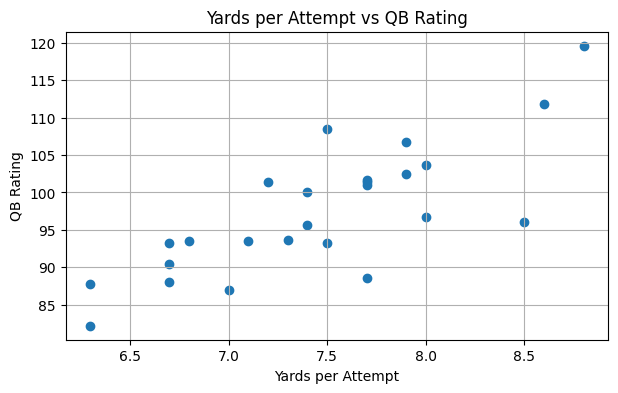

## Using the Pearson Correlation Coefficient

Pearson Correlation Coefficient: 0.7822212120035172 ✅
P value: 3.853214337575798e-06 ✅



<b>Conclusion:</b> There is a significant positive correlation between yards per attempt and QB rating.

In [35]:
qb_2024 = import_table("passing", "2024")

# Yards per Attempt vs QB Rating Graph
display(Markdown("## Do efficient passers have better ratings? Yes"))
x = qb_2024['Yds/Att']
y = qb_2024['Rate']

plt.figure(figsize=(7, 4))
plt.scatter(x, y)

plt.xlabel("Yards per Attempt")
plt.ylabel("QB Rating")
plt.title("Yards per Attempt vs QB Rating")
plt.grid(True)
plt.show()


# Statistical Evidence
# Pearson Correlation Coefficient ranges between [-1, 1]; measures strength/direction of relationship
# p value tests statistical significance; < 0.05 unlikely to be coincidental
display(Markdown("## Using the Pearson Correlation Coefficient"))
pcc, p_val =  pearsonr(qb_2024['Yds/Att'], qb_2024['Rate'])
print(f"Pearson Correlation Coefficient: {pcc} ✅")
print(f"P value: {p_val} ✅\n")
display(Markdown("<b>Conclusion:</b> There is a significant positive correlation between yards per attempt and QB rating."))

## Do high-volume QBs score more TDs?

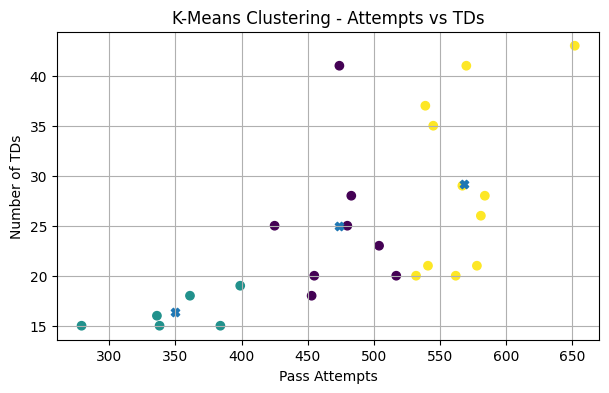

## Using the T-test

T-statistic: 2.207793806091292
p-value: 0.037503667873498514


<b>Conclusion:</b> There is a significant positive correlation between high-volume QBs and number of TDs scored.

In [36]:
# Yards per Attempt vs QB Rating Graph
# Include KMeans clustering
display(Markdown("## Do high-volume QBs score more TDs?"))
x = qb_2024['Att']
y = qb_2024['TD']

# Combine both columns into a 2D array for KMeans()
X = np.column_stack((x, y))

# Use 3 clusters, pick 3 centroids, assign each point to a centroid
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
plt.figure(figsize=(7, 4))

# Use label to color each point
scatter = plt.scatter(x, y, c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="X")

plt.xlabel("Pass Attempts")
plt.ylabel("Number of TDs")
plt.title("K-Means Clustering - Attempts vs TDs")
plt.grid(True)
plt.show()

# T-test
# The further from 0 the T-statistic, the larger the difference
# p value tests statistical significance; < 0.05 unlikely to be coincidental
display(Markdown("## Using the T-test"))
median_att = qb_2024['Att'].median()
high_volume = qb_2024[qb_2024['Att'] > median_att]['TD']
low_volume = qb_2024[qb_2024['Att'] <= median_att]['TD']
t_stat, p_val = ttest_ind(high_volume, low_volume)

print(f"T-statistic: {t_stat:}\np-value: {p_val}")
display(Markdown("<b>Conclusion:</b> There is a significant positive correlation between high-volume QBs and number of TDs scored."))

## What is the trade-off between aggressive scoring and turnovers?

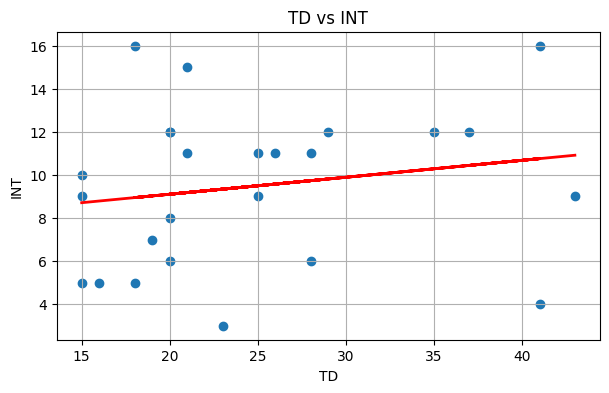

## Linear Regression

Slope: 0.07870517296096477
Intercept: 7.531259917486513


<b>Conclusion:</b> There is a positive correlation between aggressive scoring and turnovers; however, it is minimal.

In [37]:
# TD vs INT Graph
display(Markdown("## What is the trade-off between aggressive scoring and turnovers?"))
x = qb_2024['TD']
y = qb_2024['INT']

plt.figure(figsize=(7, 4))
plt.scatter(x, y)
plt.xlabel("TD")
plt.ylabel("INT")
plt.title("TD vs INT")
plt.grid(True)

# Linear Regression
x = qb_2024[['TD']].values
y = qb_2024['INT'].values
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red', linewidth=2, label='Regression line')  # Regression line
plt.show()

# If slope is positive, more risk = more reward
# Intercept is the expected number of INTs when a QB throws 0 TDs
display(Markdown("## Linear Regression"))
print(f"Slope: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
display(Markdown("<b>Conclusion:</b> There is a positive correlation between aggressive scoring and turnovers; however, it is minimal."))

# Running Backs
---

## Do top running backs get most of their yards from short runs or do long runs make a big difference?

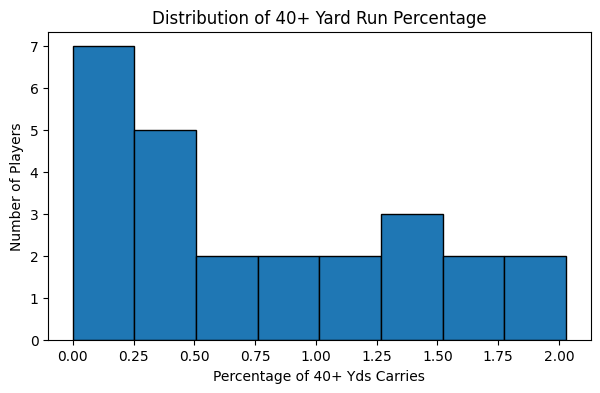

## One Sample T-test

T-statistic: -17.092433393356306 
P-value: 6.121933246658784e-15



<b>Conclusion:</b> The average 40+% yards is 17 standard deviations less than the tested 3%.

Running backs rely on consistent short runs far more than rare explosive breakaway runs.

In [38]:
# Percentage of 40+ out of all attempts graph
display(Markdown("## Do top running backs get most of their yards from short runs or do long runs make a big difference?"))

rushing_2024 = import_table("rushing", "2024")

rushing_2024["40+%"] = (rushing_2024["40+"] / rushing_2024["Att"]) * 100
plt.figure(figsize=(7, 4))
plt.hist(rushing_2024["40+%"], bins=8, edgecolor='black')
plt.title("Distribution of 40+ Yard Run Percentage")
plt.xlabel("Percentage of 40+ Yds Carries")
plt.ylabel("Number of Players")
plt.show()

display(Markdown("## One Sample T-test"))
# Check if average 40+ yard run rate is < 3%
test_value = 3.0
t_stat, p_value = stats.ttest_1samp(rushing_2024['40+%'], test_value)
print(f"T-statistic: {t_stat} ")
print(f"P-value: {p_value:}\n")

display(Markdown("<b>Conclusion:</b> The average 40+% yards is 17 standard deviations less than the tested 3%."))
display(Markdown("Running backs rely on consistent short runs far more than rare explosive breakaway runs."))

## How efficient are running backs on a per-carry basis?

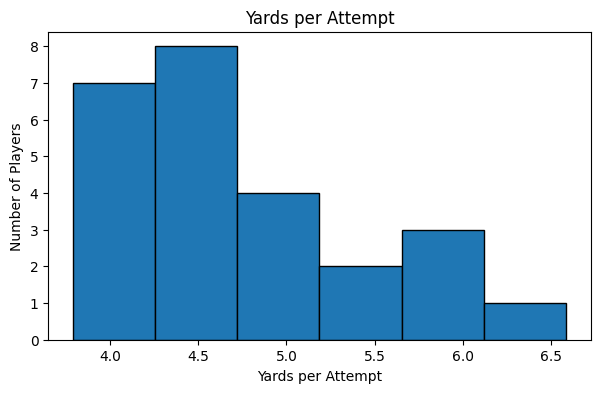

## One Sample T-test

T-statistic: 5.2229
P-value: 0.0000


'\nThese Running Backs are significantly more efficient than 4 yards per carry.\n'

In [39]:
# Yards Per Attempt graph
display(Markdown("## How efficient are running backs on a per-carry basis?"))

rushing_2024["YdsPerAtt"] = rushing_2024["Rush Yds"] / rushing_2024["Att"]

plt.figure(figsize=(7, 4))
plt.hist(rushing_2024["YdsPerAtt"], bins=6, edgecolor="black")
plt.title("Yards per Attempt")
plt.xlabel("Yards per Attempt")
plt.ylabel("Number of Players")
plt.show()


display(Markdown("## One Sample T-test"))
# Run one-sample t-test
t_stat, p_val = ttest_1samp(rushing_2024['YdsPerAtt'], 4.0)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")


"""
These Running Backs are significantly more efficient than 4 yards per carry.
"""

# Wide Receivers

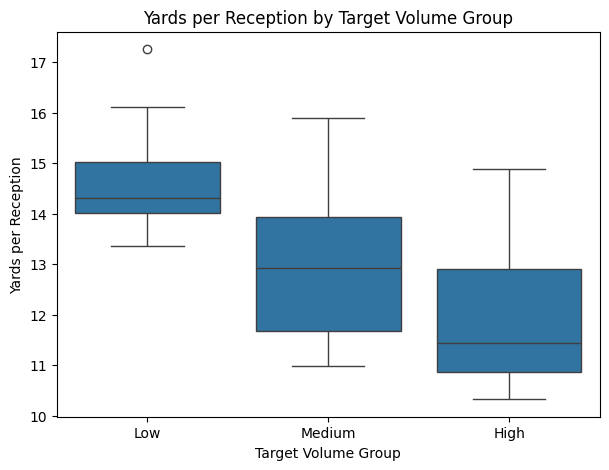

ANOVA: F-stat = 7.1832, p = 0.0040


In [40]:
"""
Do WRs with more targets have different yards per reception?


ANOVA
F-statistic
  the between-group variance (difference in mean Yds/Rec across target-volume groups) is much larger than the within-group variance
p-value = 0.0040 - very strong evidence against the null hypothesis Since p < 0.05, we reject the null
Conclusion
  Yes, wide receiver efficiency (yards per catch) significantly differs across low-, medium-, and high-target workloads.
  High-target receivers tend to be less efficient (shorter routes, possession guys), while low-target receivers tend to be more explosive.

"""
receiving_2024 = import_table("receiving", "2024")

# Add Yards per Reception column
receiving_2024["YdsPerRec"] = receiving_2024["Yds"] / receiving_2024["Rec"]

# Bin players by target volume (low, medium, high)
receiving_2024["TargetGroup"] = pd.qcut(receiving_2024["Tgts"], q=3, labels=["Low", "Medium", "High"])

plt.figure(figsize=(7,5))
sb.boxplot(x="TargetGroup", y="YdsPerRec", data=receiving_2024)
plt.title("Yards per Reception by Target Volume Group")
plt.xlabel("Target Volume Group")
plt.ylabel("Yards per Reception")
plt.show()

# Split groups
low = receiving_2024[receiving_2024["TargetGroup"] == "Low"]["YdsPerRec"]
medium = receiving_2024[receiving_2024["TargetGroup"] == "Medium"]["YdsPerRec"]
high = receiving_2024[receiving_2024["TargetGroup"] == "High"]["YdsPerRec"]

# One-Way ANOVA
anova_stat, anova_p = f_oneway(low, medium, high)
print(f"ANOVA: F-stat = {anova_stat:.4f}, p = {anova_p:.4f}")


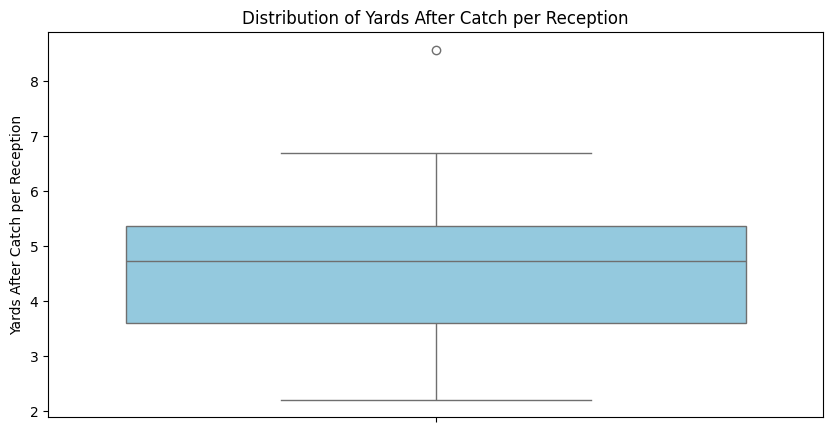

Spearman correlation: 0.0972
P-value: 0.6440


In [41]:

"""
How does yards after catch (YAC) per reception vary across receivers?

Spearman correlation
  This measures the monotonic relationship between targets (Tgts) and touchdowns (TD).
  0.0972 is very close to zero, meaning there is almost no relationship between a WR’s target volume and the number of touchdowns they scored.
P-value
  This tests the null hypothesis: there is no correlation between targets and TDs.
  p = 0.6440 is much greater than 0.05, so we fail to reject the null hypothesis.

Conclusion
  More targets do not guarantee more touchdowns among these WRs.
  High-volume receivers may not always be the primary TD scorers; some lower-target, explosive receivers can score just as much or more.
"""
receiving_2024["YACperRec"] = receiving_2024["Rec YAC/R"] / receiving_2024["Rec"]

plt.figure(figsize=(10,5))
sb.boxplot(y="YACperRec", data=receiving_2024, color="skyblue")
plt.title("Distribution of Yards After Catch per Reception")
plt.ylabel("Yards After Catch per Reception")
plt.show()

# Compute Spearman correlation directly from the DataFrame
spearman_corr, p_value = spearmanr(receiving_2024["Tgts"], receiving_2024["TD"])

print(f"Spearman correlation: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")